# Computing RFM Values

Dividing customers into different segments based on the RFM score

Logic: 

1. Package and Data Import 
2. Data Prep and Clean
3. Exploratory Analysis
4. RFM Analysis

I am going to use K-means clustering following step 4 to group customer segments based on RFM results. To validate that this K-means analysis is accurate, I am going to use Silhouette Score. 

Reference: "RFM Model for customer purchase behavior using K-Mean algorithm" P.Anitha, Malini M. Patil, 2019, from Journal of King Saud University - Computer and Information Sciences

**Required Inputs**

InvoiceNo	
Quantity
InvoiceDate	
UnitPrice	
CustomerID


## Import Packages and Data

In [102]:
# essentials packages for dataframe, computation, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as pyoff
import plotly.graph_objs as go

# machine learning, predictive analysis
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import feature_engine
from feature_engine.outliers import Winsorizer

# datatime
import datetime as dt

# warnings
import warnings
warnings.filterwarnings("ignore")

### Data Import

In [103]:
df = pd.read_csv('Online Retail.csv', encoding='utf-8-sig')
df.head()
#df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [104]:
df.shape

(541909, 8)

### Data Observation

In [105]:
# creating a dataframe to describe the data and to sort data based on data shape

def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346
Description,object,540455,4224,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,object,541909,23260,0,1/10/11 10:04
InvoiceNo,object,541909,25900,0,536365
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,10002
UnitPrice,float64,541909,1630,0,-11062.1


**OBSERVATION**

Based on this summary of the data shape, the following cleaning steps need to be done:

1. Drop all Null records, K-means cannot process missing values
2. Remove all negative Quantity and UnitPrice data, these data do not represent actually sales
3. Invoice date should be datetime instead of object


In [106]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [107]:
# observing negative UnitPrice and Quantity data

df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/11 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/11 14:52,-11062.06,NaN,United Kingdom


In [108]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/10 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/10 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/10 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/11 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/11 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/11 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/11 11:58,1.25,17315.0,United Kingdom


**OBSERVATION**

There are negative values for Unitprice to "Adjust bad debt" and negative Quantity could represent cancelled/returned orders. I am going to remove these values as they do not represent actual sales. 

## Data Clean

### Remove Nulls

In [109]:
# percentage of null vaues in the dataframe
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

25% null values, and they all come from CustomerID. With Windsor data, I would attempt to fill in any missing values if possible. If not, these need to be removed.

In [110]:
# removing nulls
df = df[pd.notnull(df['CustomerID'])]
df.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

### Remove negative values

In [111]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


### Convert InvoiceDate date type to Datetime

In [112]:
# Object to Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# add new columns for year-month and date
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         397884 non-null  object        
 1   StockCode         397884 non-null  object        
 2   Description       397884 non-null  object        
 3   Quantity          397884 non-null  int64         
 4   InvoiceDate       397884 non-null  datetime64[ns]
 5   UnitPrice         397884 non-null  float64       
 6   CustomerID        397884 non-null  float64       
 7   Country           397884 non-null  object        
 8   InvoiceYearMonth  397884 non-null  int64         
 9   Date              397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 33.4+ MB


In [113]:
#convert Date data type to datetime
df['Date']=pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         397884 non-null  object        
 1   StockCode         397884 non-null  object        
 2   Description       397884 non-null  object        
 3   Quantity          397884 non-null  int64         
 4   InvoiceDate       397884 non-null  datetime64[ns]
 5   UnitPrice         397884 non-null  float64       
 6   CustomerID        397884 non-null  float64       
 7   Country           397884 non-null  object        
 8   InvoiceYearMonth  397884 non-null  int64         
 9   Date              397884 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 33.4+ MB


In [114]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01


### Select Country

In [115]:
df.Country.value_counts(normalize=True) * 100

United Kingdom          89.051332
Germany                  2.272019
France                   2.096340
EIRE                     1.818621
Spain                    0.624303
Netherlands              0.592886
Belgium                  0.510450
Switzerland              0.462698
Portugal                 0.367444
Australia                0.297072
Norway                   0.269174
Italy                    0.190508
Channel Islands          0.187994
Finland                  0.172161
Cyprus                   0.154316
Sweden                   0.113350
Austria                  0.100029
Denmark                  0.095505
Poland                   0.082939
Japan                    0.080677
Israel                   0.062330
Unspecified              0.061324
Singapore                0.055795
Iceland                  0.045742
USA                      0.044988
Canada                   0.037951
Greece                   0.036443
Malta                    0.028149
United Arab Emirates     0.017090
European Commu

**OBSERVATION**: it seems like this dataset has majority of the data for the UK, I am going to analyze UK data.

In [116]:
df = df[df.Country == 'United Kingdom']
df.Country.value_counts(normalize = True)

United Kingdom    1.0
Name: Country, dtype: float64

***Crucial Information For this FRM Model***

* Customer ID
* Unit Price
* Quantity
* Invoice Date

## Exploratory Analysis

This analysis observes for the followings:

1. Order volume over time
2. Revenue over time
3. Monthly Revenue

### Aggregating Orders by Month

To observe monthly sales volume

In [117]:
# aggregate orders by month
df_agg = df.groupby('Date').Quantity.sum()
df_agg

Date
2010-12-01    267767
2011-01-01    278251
2011-02-01    213375
2011-03-01    276304
2011-04-01    260448
2011-05-01    301824
2011-06-01    280974
2011-07-01    303601
2011-08-01    310831
2011-09-01    454559
2011-10-01    476984
2011-11-01    571215
2011-12-01    260607
Name: Quantity, dtype: int64

In [118]:
# create a dataframe for monthly sales volume
df_agg = pd.DataFrame(df_agg)
df_agg = df_agg.reset_index()
df_agg.head()

,Date,Quantity
0,2010-12-01,267767
1,2011-01-01,278251
2,2011-02-01,213375
3,2011-03-01,276304
4,2011-04-01,260448


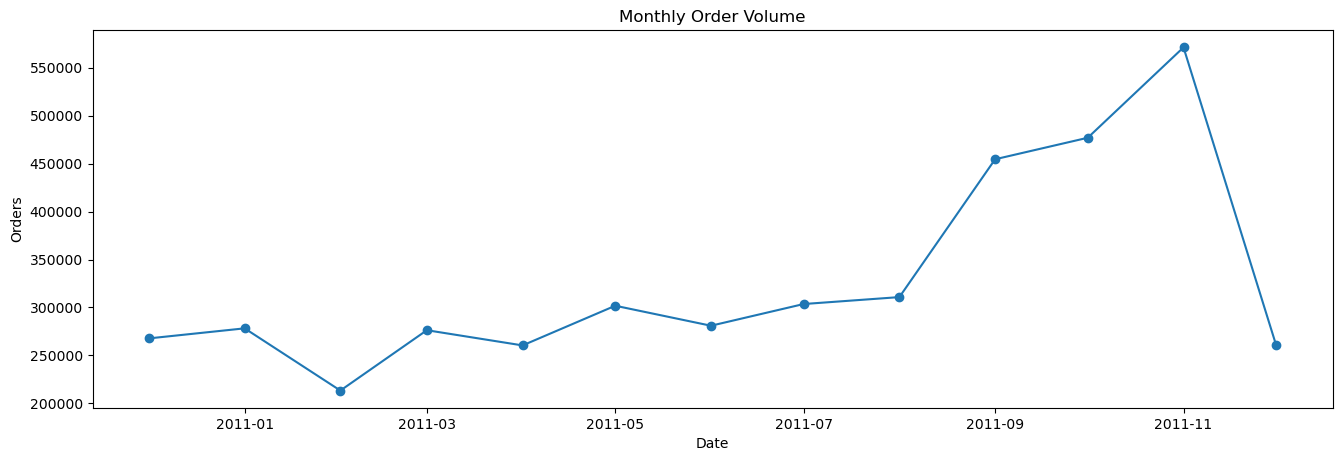

In [119]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()
    
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity, title='Monthly Order Volume')

### Revenue per Order

Revenue = Order Count * Average Revenue per Order

In [120]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12-01,20.34


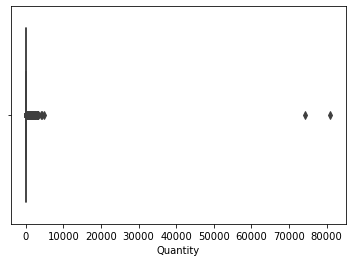

In [121]:
sns.boxplot(x=df['Quantity'])

### Monthly Revenue

In [122]:
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.tail()   #using tail to make sure there ar 12 months

,InvoiceYearMonth,Revenue
8,201108,498453.320
9,201109,796780.272
10,201110,824766.220
11,201111,980645.750
12,201112,472384.170


In [123]:
# plotting monthly revenue

plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## RFM Analysis

I am going to calculate values for Recency, Frequency, and Monetary. These three values will make up for RFM value that will be used for K-means clustering analysis. 

* Recency: number of date since last purchased. I am using 'Now' date - last invoice date.
* Frequency: how often customer buys. I am going to examine number of invoice per customer.
* Monetary: total value of purchases from each customer. I am going to compute for the sum of sales value of all orders for each customer.

### Recency

In [124]:
# what's the last invoice date overall?
df['Date'].min(), df['Date'].max()

(Timestamp('2010-12-01 00:00:00'), Timestamp('2011-12-01 00:00:00'))

In [125]:
# last invoice date is 2011-12-09, using this date to calculate recency
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [126]:
# calculate for recency value
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


### Frequency and Monetary

In [127]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


### RFM Table

In [128]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [129]:
# double checking recency for customerID 12346
(NOW - dt.date(2011,1,18)).days == 325

True

### Condition for RFM Quartiles

Splitting rfm metrics into segments using quantiles. Will assign a score from 1 to 4 for each recency, frequency, and monetary. 1 is the highest, 4 is the lowest. At the end, I will combine these scores to create the final RFM score.

In [130]:
# creating quantile
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

segmented_rfm = RFM_Table.copy()

In [131]:
# defining the condition for recency score, opposite of the other two because smaller recency is good
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# defining the condition for frequency and monetary scores, larger frequency and monetary score is good
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [132]:
# create quantile dataframe
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4595,33719.73,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2


### RFM Segment and Score

RFM_Score = R_quartile + F_quartile + M_quartile

In [133]:
# combining all three quartile values to calculate for FRM segment
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4595,33719.73,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [134]:
# summing up the rfm quartile to create rfm score
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5


In [135]:
# insight on our customer groups
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


In [136]:
# finding all the unique rfm score
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4])

In [137]:
# rfm score table and info
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             6.6     363.7   8218.2   409
4            20.3     187.0   3492.1   345
5            32.0     113.3   1909.4   386
6            47.0      78.9   1806.6   380
7            60.5      55.4    917.1   408
8            78.1      38.5    733.0   393
9            96.7      28.4    829.5   424
10          153.0      21.0    357.0   470
11          174.0      13.7    234.2   362
12          257.9       8.1    152.3   343

The lower the FRM_score, the more valueble the customer.

# K-Means Clusterings

Using k-means clustering to group customers based on their rfm scores. Windsor can use outputs from this insights to do target each group of customers with different marketing treatment for best sales/retention results based on cusomters purchasing behavior.

**For this analysis, I will validate the data quality and kmeans in two ways:**

1. Plotting distribution charts to check for skewness
2. Silhouette Score

k-means works well when the data is not skewed

## Skewness

A normally distributed (or close to normal) target variable helps in better modeling the relationship between target and independent variables.

Recency's: Skew: 1.244516494686479, : SkewtestResult(statistic=25.283720058978158, pvalue=4.8246481722257944e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary's: Skew: 20.190728787200957, : SkewtestResult(statistic=81.75346911703686, pvalue=0.0)


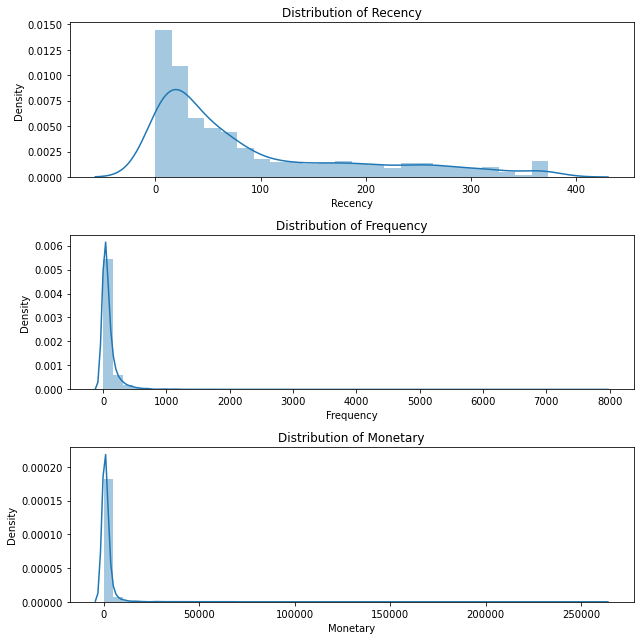

In [138]:
## function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

All three graphs are highly skewed. Log transformation will be used to reduce the skewness of each variable. 

In [139]:
# another way to view this table
#cols=['Recency','Frequency','Monetary']
#df_rfm_log = RFM_Table[cols]

In [140]:
# viewing RFM_table and create a new variable for it
df_rfm_log = RFM_Table.copy()
df_rfm_log.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


### Log Transformation to Normalize Skewed Data

Recency's: Skew: -0.4635591539552193, : SkewtestResult(statistic=-11.314301280234206, pvalue=1.114869536941138e-29)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary's: Skew: 0.3694308288045071, : SkewtestResult(statistic=9.166088768517884, pvalue=4.904929990328552e-20)


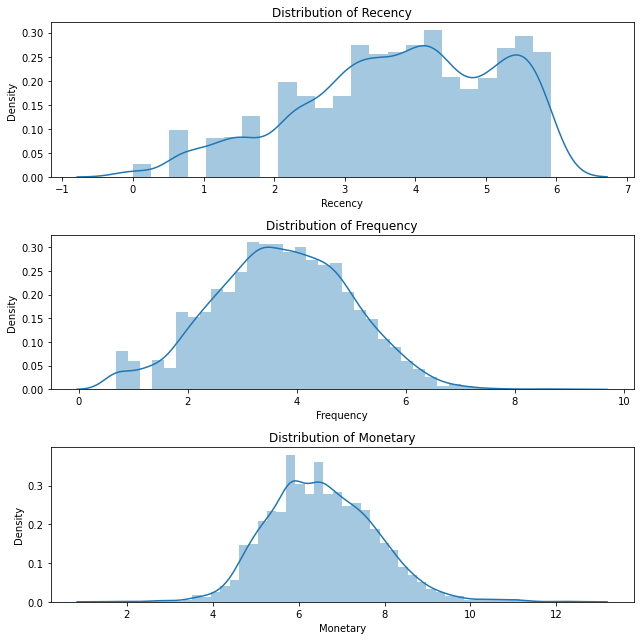

In [141]:
# using log transformation to reduce skewness
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [142]:
RFM_Table.describe()    # before log
#df_rfm_log.describe()   # after log

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


### Windsorizer

To minimize the influence of outlier on the dataset

In [143]:
# capping the ends of the tails
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [144]:
# new variable for rfm dataframe
df_rfm_log = windsoriser.transform(df_rfm_log)
df_rfm_log.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,9.647473,3.814659,3.722912,6.531629
std,0.102110,1.346136,1.215050,1.166840
min,9.421168,1.034064,1.201084,4.058839
25%,9.561684,2.890372,2.890372,5.708040
50%,9.653133,3.931826,3.737670,6.482006
75%,9.735912,4.962845,4.607658,7.363650
max,9.814000,5.924256,6.241635,9.033484


### Standardizing 

Centring and scaling to standardize the data after the skewness is reduced.

In [145]:
# standardizing rf_rfm_log table
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_Table_scaled = scaler.transform(df_rfm_log)

RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-2.216570,1.465297,-2.075758,2.144403
1,-1.903521,-2.017919,0.758484,1.551824
2,-1.902753,-2.065875,2.073202,2.144403
3,-1.901985,-1.804182,1.296742,1.530081
4,-1.847594,-1.804182,0.305732,0.272393


In [146]:
RFM_Table_scaled.describe()

,CustomerID,Recency,Frequency,Monetary
count,3.920000e+03,3.920000e+03,3.920000e+03,3.920000e+03
mean,1.821310e-14,-2.084500e-17,-2.614689e-16,1.486339e-16
std,1.000128e+00,1.000128e+00,1.000128e+00,1.000128e+00
min,-2.216570e+00,-2.065875e+00,-2.075758e+00,-2.119490e+00
25%,-8.402751e-01,-6.867101e-01,-6.852780e-01,-7.059186e-01
50%,5.544184e-02,8.705020e-02,1.214684e-02,-4.253319e-02
75%,8.662257e-01,8.530578e-01,7.282484e-01,7.131466e-01
max,1.631076e+00,1.567349e+00,2.073202e+00,2.144403e+00


## Elbow Method

In [147]:
# initiate calculation
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

### Using Distortion

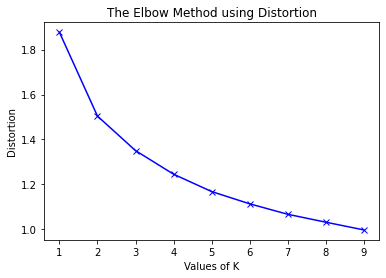

In [148]:
# elbow plot using distortions
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

### Using Inertia

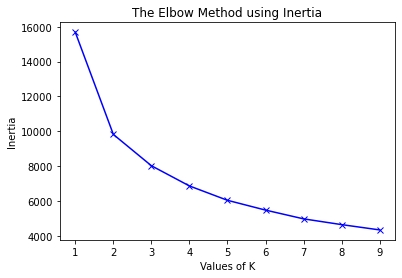

In [149]:
# elbow plot using inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Where inertia value becomes constants indicates optimal number of clusters. I am going to choose between 4 to 7.

## Defining & Visualizing K-Means

In [150]:
# initiate kmeans
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

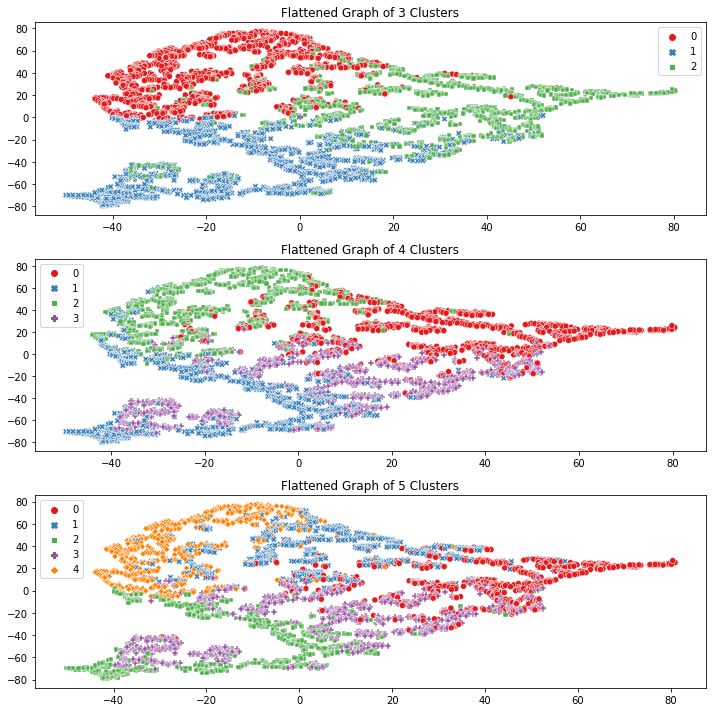

In [151]:
# kmean flattened graph
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

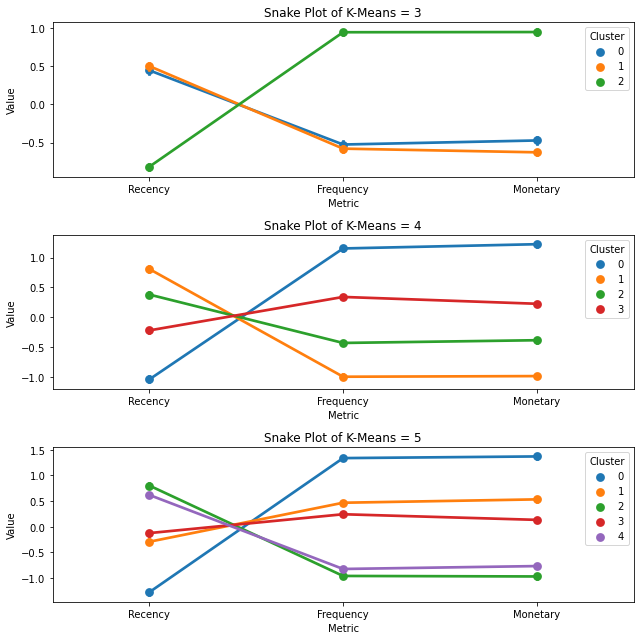

In [152]:
# using snake plot to see which cluster has the best separation

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

4 clusters seem to have the best degree of seperation. Number of clusters also depends on how Windsor wants to segment customers.

## Interpreting Cluster Result

In [153]:
# creating cluster table for 4 clusters
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          18.0     254.0   5775.0   876
1         180.0      15.0    275.0   912
2         115.0      32.0    703.0  1073
3          53.0      79.0   1175.0  1059

Cluster 0: Best customers

Cluster 1: Passerby customers, last purchase is long ago, spend little, and not frequency

Cluster 2: Likely to churn, haven't purchase in a while, but used to purchase frequently and spend a lot

Cluster 3: Very loyal customers, spend a lot

# Silhouette Score

Validating Kmeans, measuring the degree of seperation between clusters and comparing it with the plots to make sure kmeans works as it should.

In [154]:
# Import packages for silhouette score
from sklearn.metrics import silhouette_score

In [163]:
KMean= KMeans(n_clusters=2)
KMean.fit(RFM_Table_scaled)
label=KMean.predict(RFM_Table_scaled)

print(f'Silhouette Score(n=2): {silhouette_score(RFM_Table_scaled, label)}')

Silhouette Score(n=2): 0.31400077841894436


In [160]:
KMean= KMeans(n_clusters=3)
KMean.fit(RFM_Table_scaled)
label=KMean.predict(RFM_Table_scaled)

print(f'Silhouette Score(n=3): {silhouette_score(RFM_Table_scaled, label)}')

Silhouette Score(n=3): 0.26603821875798506


In [161]:
KMean= KMeans(n_clusters=4)
KMean.fit(RFM_Table_scaled)
label=KMean.predict(RFM_Table_scaled)

print(f'Silhouette Score(n=4): {silhouette_score(RFM_Table_scaled, label)}')

Silhouette Score(n=4): 0.24070200942440814


In [162]:
KMean= KMeans(n_clusters=5)
KMean.fit(RFM_Table_scaled)
label=KMean.predict(RFM_Table_scaled)

print(f'Silhouette Score(n=5): {silhouette_score(RFM_Table_scaled, label)}')

Silhouette Score(n=5): 0.2286031501966664
